# 0.0 Business Problem

Como um Consultor de Ciência de Dados para criar um modelo de alta precisão e acurácia na detecção de fraudes de transações feitas através de dispositivos móveis.

Entregaveis da consultoria:

- Modelo em produção com API.
- Relatório reportando a performance e os resultados do seu modelo em relação ao lucro e prejuízo que a empresa terá ao usar o modelo que você produziu.

  No seu relatório deve conter as respostas para as seguintes perguntas:

 -   Qual a Precisão e Acurácia do modelo?
 -   Qual a Confiabilidade do modelo em classificar as transações como legítimas ou fraudulentas?
 -   Qual o Faturamento Esperado pela Empresa se classificarmos 100% das transações com o modelo?
 -   Qual o Prejuízo Esperado pela Empresa em caso de falha do modelo?
 -   Qual o Lucro Esperado pela Blocker Fraud Company ao utilizar o modelo?

Data source: [Link](https://www.kaggle.com/ntnu-testimon/paysim1)

# 0.1 Imports

In [20]:
# Importings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from MyToolBox import MyToolBox

In [24]:
# Helper Functions  trans_fraud_data.csv

def get_data(path, target, kind='train'):
    if kind == 'train':
        train = pd.read_csv(path)
        X = train.drop(target, axis=1)
        y = train[target]
    else:
        test = pd.read_csv(path)
        X = test.copy()

    return train, X, y

def balanced_target(target, dataset, hue=None):
    """
    Function to check the balancing of the target variable.

    :target:  An pd.Series of the target variable that will be checked.
    :dataset: An Dataframe object. 
    """
    sns.set(style='darkgrid', palette='Accent')
    ax = sns.countplot(x=target, hue=hue, data=dataset)
    ax.figure.set_size_inches(10, 6)
    ax.set_title('Target Distribution', fontsize=18, loc='center')
    ax.set_xlabel(target, fontsize=14)
    ax.set_ylabel('Count', fontsize=14)
    ax=ax

def hipo_test(*samples):

    samples = samples

    try:
        if len(samples) == 2:
            stat, p = ttest_ind(*samples)
        elif len(samples) > 2:
            stat, p = f_oneway(*samples)
    except:
        raise Exception("Deve ser fornecido pelo menos duas samples!!!")

    if p < 0.05:
        print(f'O valor de p é: {p}')
        print('Provável haver diferença')
    else:
        print(f'O valor de p é: {p}')
        print('Provável que não haja diferença')

    return stat, p

# 1.0 Collect Data

In [39]:
train, X, y = get_data(path='../data/trans_fraud_data.csv', target='isFraud')
print(f'Quantidade de Colunas {train.shape[1]}')
print(f'Quantidade de Observações {train.shape[0]}')
train.head()

Quantidade de Colunas 11
Quantidade de Observações 6362620


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


# 2.0 Data Description

In [4]:
pd.DataFrame({'missingPerc': train.isna().mean(),
              'uniques': train.nunique(),
              '%uniquePerc': (train.nunique()/train.shape[0])*100,
              'data_types': train.dtypes})

,missingPerc,uniques,%uniquePerc,data_types
step,0.0,743,0.011678,int64
type,0.0,5,0.000079,object
amount,0.0,5316900,83.564632,float64
nameOrig,0.0,6353307,99.853629,object
oldbalanceOrg,0.0,1845844,29.010753,float64
newbalanceOrig,0.0,2682586,42.161657,float64
nameDest,0.0,2722362,42.786808,object
oldbalanceDest,0.0,3614697,56.811455,float64
newbalanceDest,0.0,3555499,55.881052,float64
isFraud,0.0,2,0.000031,int64


## 2.1 isFraud vs isFlaggedFraud

- Bastante desbalanciado
- isFlaggedFraud possui somente 16 observações, podemos nos desfazer dessa variável.

Quantidade de eventos positivos - isFraud- 8213
Percentual de eventos positivos - isFraud- 0.12908204481801522

Quantidade de eventos positivos - isFlaggedFraud- 16
Percentual de eventos positivos - isFlaggedFraud- 0.12908204481801522



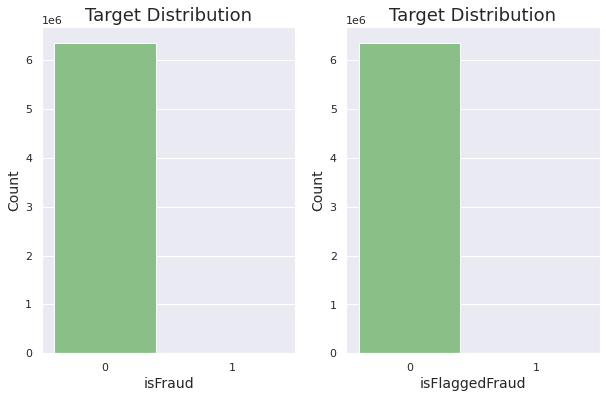

In [25]:
quant = train['isFraud'].sum()
perc = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFraud- {quant}')
print(f'Percentual de eventos positivos - isFraud- {perc}\n')

quant1 = train['isFlaggedFraud'].sum()
perc1 = (quant/train.shape[0])*100
print(f'Quantidade de eventos positivos - isFlaggedFraud- {quant1}')
print(f'Percentual de eventos positivos - isFlaggedFraud- {perc1}\n')


#Plots
plt.subplot(1,2,1)
balanced_target('isFraud', dataset=train)

plt.subplot(1,2,2)
balanced_target('isFlaggedFraud', dataset=train)

# 2.2 Outras variáveis 
- Operações com destino tipo 'Merchant' tanto old quanto newbalance é igual a 0.

In [26]:
# Describe
variables = ['step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']
train[variables].describe().T

,count,mean,std,min,25%,50%,75%,max
step,6362620.0,2.433972e+02,1.423320e+02,1.0,156.00,239.000,3.350000e+02,7.430000e+02
amount,6362620.0,1.798619e+05,6.038582e+05,0.0,13389.57,74871.940,2.087215e+05,9.244552e+07
oldbalanceOrg,6362620.0,8.338831e+05,2.888243e+06,0.0,0.00,14208.000,1.073152e+05,5.958504e+07
newbalanceOrig,6362620.0,8.551137e+05,2.924049e+06,0.0,0.00,0.000,1.442584e+05,4.958504e+07
oldbalanceDest,6362620.0,1.100702e+06,3.399180e+06,0.0,0.00,132705.665,9.430367e+05,3.560159e+08
newbalanceDest,6362620.0,1.224996e+06,3.674129e+06,0.0,0.00,214661.440,1.111909e+06,3.561793e+08


In [40]:
# Analisando os tipos de destino
train_temp = train.copy()
train_temp['dest_type'] = train_temp['nameDest'].apply(lambda x : 'Customer' if x[0]=='C' else 'Merchant')

In [48]:
merchant = train_temp.loc[train_temp['dest_type']=='Merchant',]
merchant['newbalanceOrig'].unique()

array([160296.36,  19384.72,  29885.86, ...,  22526.53,   1411.43,
       510167.71])

In [ ]:
# Analisando Olds balances igual a 0
train_temp1 = train.copy()

# 3.0 Split Data

# 4.0 Mapa de Hipoteses

# 5.0 Feature Engineering

# 6.0 EDA

Lista de Hipoteses!

1. 